# Автоматическая обработка текстов 
## Домашнее задание 1 [10 баллов] до 23:59 15.03.2018

В этом домашнем задании вам потребуется написать генератор описания прогноза погоды на следующую неделю в каком-нибудь городе. Домашнее задание состоит из трех частей:
1. Скачивание данных о состоянии погоды в городе 
2. Генерация описания прогноза
3. Творческая часть

Все три части можно считать независимыми – вы можете сделать одну или две из них, однако мы настоятельно советуем выполнить все три. Все инструкции по выполнению домашнего задания – ниже. 



### 1. Сбор данных [3 балла]


Пример: прогноз на 10 ближайших дней в Москве – https://www.gismeteo.ru/weather-moscow-4368/10-days/

Используя известные вам библиотеки для работы с протоколом http и html кодом, извлеките прогноз на ближайшие 10 дней, начиная со дня, когда вы начали делать домашнее задание, с любого сервиса с прогнозом погоды или используя его API.
Примеры сервисов:
* gismeteo.ru, https://www.gismeteo.ru/api/ – Gismeteo, API Gismeteo 
* https://tech.yandex.ru/weather/ – API Yandex.Погоды
* https://sinoptik.com.ru – Sinoptik
* любой другой 

Резльтатом сбора данных должна быть таблица со следующими строками:
* минимальная температура
* максимальная температура
* скорость ветра
* уровень осадков 

В столбцах таблицы должны быть даты и дни недели.  Пример итоговой таблицы вы найдете в следующей части задания. 

Решено было работать с сервисом погоды от Яндекса. В качестве инструмента по извлечению данных использовалась библиотека BeautifulSoup для парсинга html страниц. Мы посчитали, что данный способ получения информации о погоде наиболее универсальный, позволяет не привязываться к фиксированному api и при желании быстро изменить место получения необходимых данных.

In [293]:
import requests
from bs4 import BeautifulSoup
import random

Изначально загрузим саму html страницу и извлечем из нее дни даты.

In [331]:
def get_nodes_text(soup, node_type, node_name):
    return list(map(lambda x: x.text, soup.find_all(node_type, node_name)))

In [332]:
site_content = requests.get('https://yandex.ru/pogoda/moscow/details')
soup = BeautifulSoup(site_content.text, 'html.parser')

In [333]:
names = get_nodes_text(soup, 'span', 'forecast-details__day-name')
days = get_nodes_text(soup, 'strong', 'forecast-details__day-number')
months = get_nodes_text(soup, 'span', 'forecast-details__day-month')


Теперь можно и о погоде подумать.

In [334]:
full_information_list = soup.find_all('tbody', 'weather-table__body')

В процессе получения значения температур мы столкнулись с проблемой, которая встречается при работе со многими сервисами от Яндекса, а именно разными кодировками. Просто так переконвертировать значения не вышло, пришлось применить не совсем красивый и удобный подход по обработки целых чисел.

In [335]:
def get_temperature_as_int(temperature):
    value = int(temperature[1:])
    if temperature[0] == '−':
        value = value * -1
    return value

In [336]:
def get_temperatures(tag):
    temp_spans = tag.find_all('td', 'weather-table__body-cell_type_daypart')
    temperatures = []
    for temp in temp_spans:
        temperatures.extend(get_nodes_text(temp, 'span', 'temp__value'))
    return list(map(get_temperature_as_int, temperatures))

In [337]:
def get_wind_speed(tag):
    values = get_nodes_text(tag, 'span', 'wind-speed')
    values = list(map(lambda x: x.replace(',', '.'), values))
    values = list(map(float, values))
    return float(format(sum(values) / len(values), '.2f'))

In [301]:
def get_pressure(tag):
    values = get_nodes_text(tag, 'td', 'weather-table__body-cell_type_air-pressure')
    values = list(map(int, values))
    return int(sum(values) / len(values))

In [338]:
min_temp = list(map(min, map(get_temperatures, full_information_list)))
max_temp = list(map(max, map(get_temperatures, full_information_list)))
wind_speed = list(map(get_wind_speed, full_information_list))
pressure = list(map(get_pressure, full_information_list))

### 2. Генератор описания прогноза погоды [4 балла]

Если у вас не получилось извлечь прогноз погоды в предыдущей части задания, воспользуйтесь таблицей ниже.
В ней приведен прогноз четырех показателей на первые 10 дней февраля в Москве – минимальная и максимальная температура, скорость ветра и уровень осадков. 

У нас все же получилось добыть прогноз погоды, но, за неимением данных об уровне осадков, пришлось использовать альтернативную информацию, а именно показания Давления.

In [327]:
def build_row_cell(index):
    return f'{days[index]} {months[index]}'

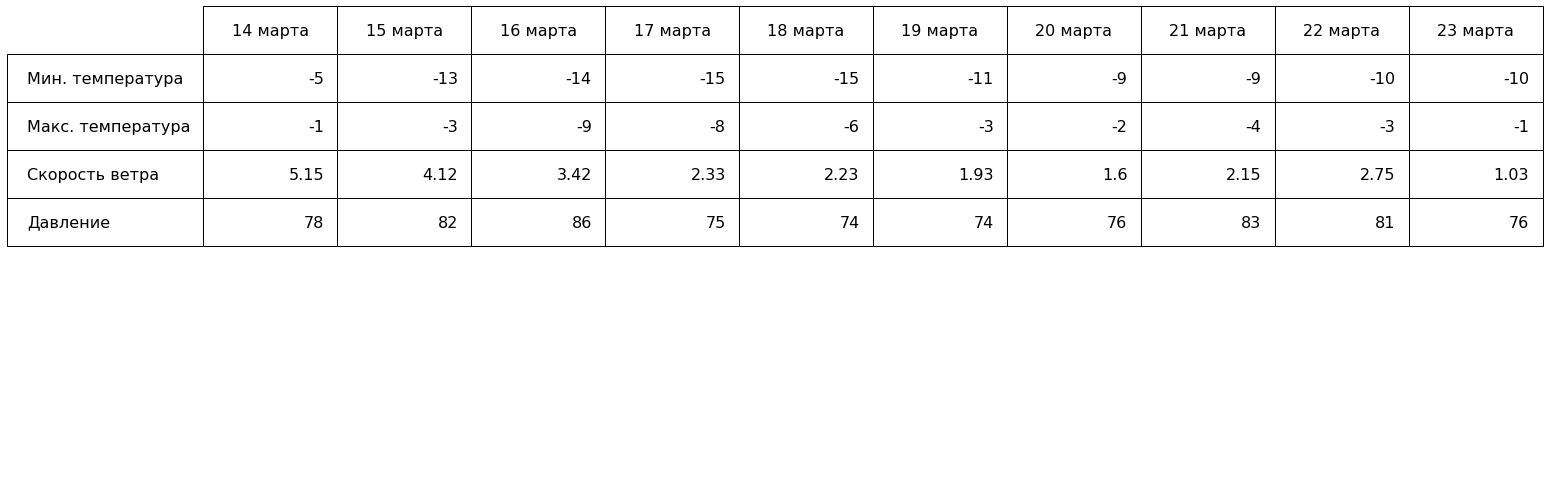

In [339]:
import matplotlib.pyplot as plt

data = [min_temp, max_temp, wind_speed, humidity]

cols = [build_row_cell(i) for i in range(len(days))]
rows = ('Мин. температура', 'Макс. температура', 'Скорость ветра', 'Давление')

fig, ax = plt.subplots()
# Hide axes
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=data, rowLabels=rows, colLabels=cols, loc='top')
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(4, 4)
plt.show()

|                | 02.02 (пт) | 03.02 (сб) | 04.02 (вс)| 05.02 (пн) | 06.02 (вт) | 07.02 (пн) | 08.02 (ср) | 09.02 (ср) | 10.02 (сб) | 11.02 (вс)
|----------------|-------|-------|-------|-------|-------|-------|-------|
| минимальная температура    | -9    | -1    | -8    | -13    | -12    | -15    | -21    | -14 |-8 |-8
| максимальная температура    | -1    | +1    | -2    | -9   | -11    | -12    | -16    |-5    |-6    |-5|
| скорость ветра | 10    | 13    | 15    | 15   |11    | 6    | 7 | 9 | 8 |12
| уровень осадков         | 1.35  | 8.6  | 15.5  | 6.6   | 2.7   | 2.1   | 0   | 3.2   |0.8  | 0.4

Прогноз погоды должен состоять из следующих (или подобным им) предложений, генерируемых по шаблонам (ниже три шаблона):
* В день1 похолодает / потеплеет на X градус (-а, -ов) по сравнению с день2
    * *В четверг в НазваниеГорода потеплеет на 7 градусов по сравнению со средой*
* Скорость ветра изменится на X единиц в день1 по сравнению с день2.
    * *Скорость ветра изменится на 3 км/час в понедельник по сравнению с пятницей*
* Уровень осадков повысится / понизится на X единиц за Y дней. 
    * *Уровень осадков понится на 3.85 мм за 7 дней*
    * *Выпадет 10 см снега за ближайшие 7 дней * 


Вместо НазваниеГорода и дней недели подставьте название выбранного вами города и дни недели, используя фунцкии для согласования существительных с предлогами. Используйте функции для согласования числительного с существительным для согласования длительности промежутков времени и слова "день" и чисел  с последующими единицами измерения.

Некоторые вспомогательные функции, которые вам понадобятся: согласование существительного с числительным и приведение существительного к нужному падежу: 

Ниже представлены примеры сгенерированных предсказаний, которые включили в себя как всю извлеченную информацию, так и задействовали все описанные в примерах подходы по морфологическому анализу.

In [305]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [306]:
def generate_preposition(prep, word):
    if prep.lower() == word[0] and word[0] == 'с' or word[0:2] == 'вт':
        prep += 'о'
    return prep

In [340]:
def generate_advanced_temperature_sample(first_day_index, second_day_index):
    assert (first_day_index < second_day_index)
    ft = int((min_temp[first_day_index] + max_temp[first_day_index]) / 2)
    st = int((min_temp[second_day_index] + max_temp[second_day_index]) / 2)
    verb = 'похолодает' if ft > st else 'потеплеет'
    degrees = abs(st - ft)
    degrees_word = 'градусы'
    correct_degrees_word = morph.parse(degrees_word)[0].make_agree_with_number(degrees).word
    prep = generate_preposition('с', names[second_day_index])
    fd = morph.parse(names[first_day_index])[0].inflect({'accs'}).word
    sd = morph.parse(names[second_day_index])[0].inflect({'ablt'}).word

    if degrees == 0:
        return f'В {fd} в Москве температура не изменится по сравнению {prep} {sd}.'

    return f'В {fd} в Москве {verb} на {degrees} {correct_degrees_word} по сравнению {prep} {sd}.'

In [308]:
def generate_simple_pressure_sample(i):
    day = names[i]
    if i >= 2:
        parsed_day = morph.parse(day)[0]
        day = generate_preposition('В', day) + ' ' + parsed_day.inflect({'accs'}).word
    else:
        day = day[0].upper() + day[1:]
    num = pressure[i]
    mm = morph.parse('милимметров')[0].make_agree_with_number(num).word
    return f'{day} давление будет состовлять {num} {mm} ртутного столба.'

In [320]:
def generate_wind_speed_sample(fi, si):
    assert (fi < si)
    speed = abs(int(wind_speed[si] - wind_speed[fi]))

    fprep = generate_preposition('в', names[fi])
    sprep = generate_preposition('с', names[si])
    fd = morph.parse(names[fi])[0].inflect({'accs'}).word
    sd = morph.parse(names[si])[0].inflect({'ablt'}).word
    km = morph.parse('киллометры')[0].make_agree_with_number(speed).word

    return f'Скорость ветра изменится на {speed} {km} в час {fprep} {fd} по сравнению {sprep} {sd}'

In [341]:
generate_advanced_temperature_sample(random.randint(2, 5), random.randint(6, 9))

'В понедельник в Москве потеплеет на 1 градус по сравнению с четвергом.'

In [342]:
generate_simple_pressure_sample(random.randint(0, 9))

'В четверг давление будет состовлять 741 милимметра ртутного столба.'

In [343]:
generate_wind_speed_sample(random.randint(2, 5), random.randint(6, 9))

'Скорость ветра изменится на 1 киллометр/час в воскресенье по сравнению с пятницей'

### 3. Ответьте на вопросы [3 балла]
* В каких других задачах (помимо описания прогноза погоды) может понадобиться генерировать текст по шаблонам? В каких задачах может понадобиться генерировать текст об изменении числовых показателей по шаблонам?
* Шаблоны, которые вы использовали в этом задании, имеют фиксированную структуру. Фактически, ваша задача заключалась в том, чтобы подставить в шаблон число и согласовать единицы измерения с этим числом или подставить в шаблон название города и согласовать его с предлогом. Как можно разнообразить эти шаблоны? Как знание синтаксической структуры предложения может помочь в этой задаче? 

На самом деле даже такой простой и плохо масштабируемый подход по предоставлению информации находит довольно-таки много применений в реальной жизни. Можно легко структурировать нужный кусочек информации среди огромного потока данных. Например, отслеживать значения курса валют или ценных бумаг. Вечером, после работы, можно посмотреть быстро глянуть на сгенерированную сводку спортивных новостей. А в конце месяца получить информацию об итоговых семейных тратах. Можно даже использовать данный подход для диагностики непрерывно работающих систем, чтобы в случае критической ситуации быстро получить краткое описание условий возникновения проблемы.

В качестве разнообразия можно вместо простых предложений использовать составные, попутно добавляя обстоятельства, например причастный оборот. По факту мы просто объединяем несколько шаблонов вместе, тем самым порождая все больше новых конструкций. 

## Сдача домашнего задания

Дедлайн сдачи домашнего задания:  23:59 15.03.2018. Каждый день просрочки дедлайна штрафуется -1 баллом.

Результаты домашнего задания должны быть оформлены в виде отчета в jupyter notebook.
Нормальный отчёт должен включать в себя:
* Краткую постановку задачи и формулировку задания
* Описание минимума необходимой теории и/или описание используемых инструментов 
* Подробный пошаговый рассказ о проделанной работе
* **Аккуратно** оформленные результаты
* Подробные и внятные ответы на все заданные вопросы 
* Внятные выводы – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

Задание выполняется в группе до трех человек. Не забудьте перечислить фамилии всех, кто работал над домашнем задании, в jupyter notebook.  

В случае использования какого-либо строннего источника информации обязательно дайте на него ссылку. Плагиат наказывается нулём баллов за задание.

При возникновении проблем с выполнением задания обращайтесь с вопросами к преподавателю по семинарским занятиям – Антону Емельянову. 

Небрежное оформление отчета существенно отразится на итоговой оценке. Весь код из отчёта должен быть воспроизводимым, если для этого нужны какие-то дополнительные действия, установленные модули и т.п. — всё это должно быть прописано в отчете в явном виде.

Сдача отчетов осуществляется через систему AnyTask.


### Как сдать домашнее задание в AnyTask
* Зарегистрируйтесь в системе AnyTask по ссылке http://anytask.org/accounts/register . Регистрация обязательна для всех!
* Подтвердите регистрацию по e-mail.
* Зайдите в свой профиль, нажмите “Активация инвайтов на курсы” и введите инвайт 0pobDsj (для всех групп). 


 У вас появится курс “МФТИ > Автоматическая обработка текстов (2018)” в разделе “Посещает курсы”.
* Перейдите по ссылке “МФТИ > Автоматическая обработка текстов (2018)” и нажмите кнопку “Сдать”. 
* У вас откроется условие задачи и будут доступны различные поля, в частности, НИЖЕ условия задачи будет поле ввода, в которое вы сможете вписать какой-то комментарий, и сможете прикрепить файл. Сделайте это.
* Домашнее задание лучше всего сдавать в форматах IPYNB.
* Оценку вы получите также в системе AnyTask. За своей успеваемостью можете следить в разделе “Ведомость”, а также можете прокомментировать что-то в каждом вашем домашнем задании, зайдя на ее страничку (ячейки в табличке на страничке “Ведомость” кликабельны и ведут на ваш submission домашки).

(**ВАЖНО**) Если домашнее задание вы делали в группе, то в AnyTask домашнее сдает *один* участник группы, но заргестрироваться в AnyTask обязательно всем – так мы сможем проставить вам оценки в ведомость в AnyTask.

Ссылка на курс в AnyTask: http://anytask.org/course/325